In [19]:
import pandas as pd
import numpy as np
import os
import sys

# Get the path of the current directory
current_dir = os.getcwd()

# Get the parent directory (because current directory is example_notebook)
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))

# Add the parent directory to sys.path
sys.path.append(parent_dir)


In [20]:
from SynPiper import SynPiper
from synthetic_evaluation import *

In [21]:
df = pd.read_csv(os.path.join(parent_dir, 'datasets', 'heartprocessed.csv'))

In [22]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0


# Parameter Processing

The required set of parameters are:
1) categorical_attributes : List of column names of categorical / discrete columns
2) epsilon : Privacy Budget. Set to 0 to turn off differential privacy and generate high fidelity datasets. To increase noise and increase privacy, set the epsilon value to (0, 1]. To introduce less noise during generation, set epsilon value > 1.
3) degree_of_bayesian_network : Number of parent nodes. A sufficient degree = 2 or 3. To model more complex dependencies between variables, increase the number parent nodes. However, this would increase the computation complexity and may reduce the generalisation due to overfitting.

In [23]:
# Selecting categorical columns
cat_cols = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal", "target"]
num_cols = [col for col in df.columns if col not in cat_cols]

In [24]:
# Mandatory parameter dictionary for DP Synthesizer
param_dict = {
    "categorical_attributes" : cat_cols,
    "epsilon" : 4, # 0 to turn off differential privacy
    "degree_of_bayesian_network" : 3 
}

# Path of data file
data_path = os.path.join(parent_dir, 'datasets', 'heartprocessed.csv')

# Choice of Synthesizer
synthesizer_name = "dpsynthesizer"

# Path of generated data
synthetic_filepath = os.path.join(os.getcwd(), 'synthetic.csv')

In [25]:
synthesizer = SynPiper(data_path = data_path, 
                       synthesizer_name = synthesizer_name, 
                       param_dict = param_dict,
                       synthetic_filepath = synthetic_filepath)

Initialising DataSynthesizer Processor
Processor initialised!


In [26]:
# Number of rows to generate
num_tuples_to_generate = 300

# Start generation
synthesizer.generate(num_tuples_to_generate = num_tuples_to_generate)

Processing input data...
================ Constructing Bayesian Network (BN) ================
Adding ROOT target
Adding attribute thalach
Adding attribute oldpeak
Adding attribute trestbps
Adding attribute cp
Adding attribute age
Adding attribute restecg
Adding attribute chol
Adding attribute thal
Adding attribute ca
Adding attribute fbs
Adding attribute slope
Adding attribute exang
Adding attribute sex
========================== BN constructed ==========================
Saving Dataset Description File
DP Synthesizer Processing Completed!
Generating 300 rows of Synthetic Data.
Successfully saved the synthetic dataset to c:\Users\User\Desktop\SynPiper\example_notebooks\synthetic.csv
Access the synthetic samples by calling .generated_samples


In [27]:
df_syn = synthesizer.generated_samples

df_syn

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,48.0,1,2,194.0,238.0,1,1,115.0,1,1.120964,3,1,6,1
1,67.0,0,3,173.0,386.0,1,0,179.0,0,0.822565,2,2,7,1
2,73.0,1,4,97.0,258.0,1,0,196.0,0,5.584230,1,3,7,1
3,56.0,0,2,133.0,175.0,0,2,201.0,1,2.311508,3,2,6,1
4,35.0,0,3,189.0,335.0,0,0,192.0,0,5.441756,2,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,49.0,1,1,183.0,200.0,1,2,74.0,1,3.303416,1,1,3,0
296,59.0,1,4,106.0,376.0,1,2,100.0,0,2.905921,3,0,3,0
297,68.0,0,1,135.0,351.0,0,2,131.0,0,3.073917,2,2,3,1
298,66.0,1,4,164.0,554.0,1,1,119.0,1,3.233896,2,0,6,1


In [28]:
tvd_table, tvd_figure = get_all_variational_differences(real_table= df, 
                                                    synthetic_table= df_syn, 
                                                    categorical_columns= cat_cols)

tvd_table

,categorical_columns,tvd_scores
0,sex,0.793232
1,cp,0.759091
2,fbs,0.631448
3,restecg,0.686801
4,exang,0.926599
5,slope,0.727374
6,ca,0.667475
7,thal,0.783939
8,target,0.944613


In [29]:
tvd_figure

In [30]:
ks_table, ks_figure = get_all_ks_scores(real_table = df,
                                        synthetic_table = df_syn,
                                        numerical_columns = num_cols)

In [31]:
ks_table

,numerical_columns,ks_scores
0,age,0.823906
1,trestbps,0.641178
2,chol,0.493838
3,thalach,0.687912
4,oldpeak,0.495017


In [32]:
ks_figure

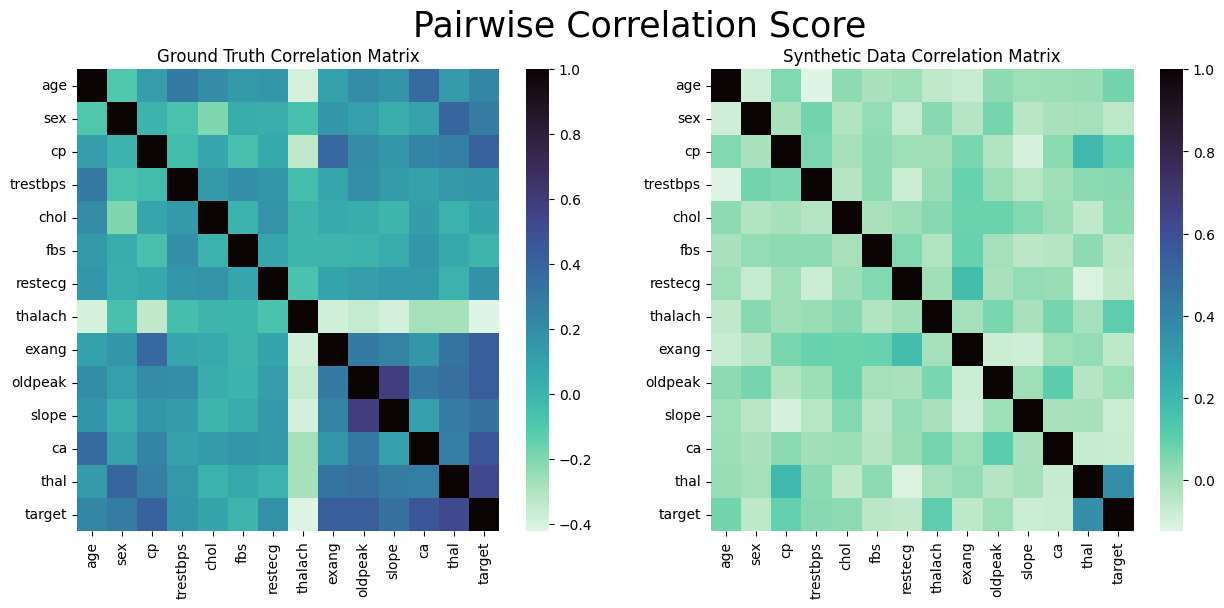

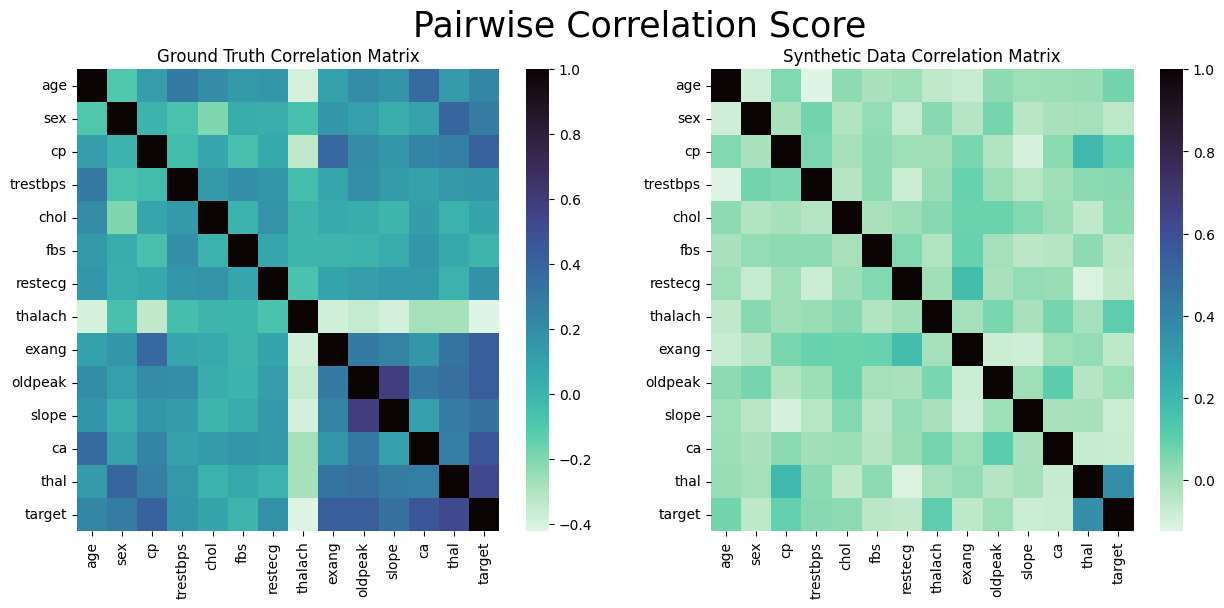

In [33]:
plot_corr_matrix(real = df,
                synthetic = df_syn)


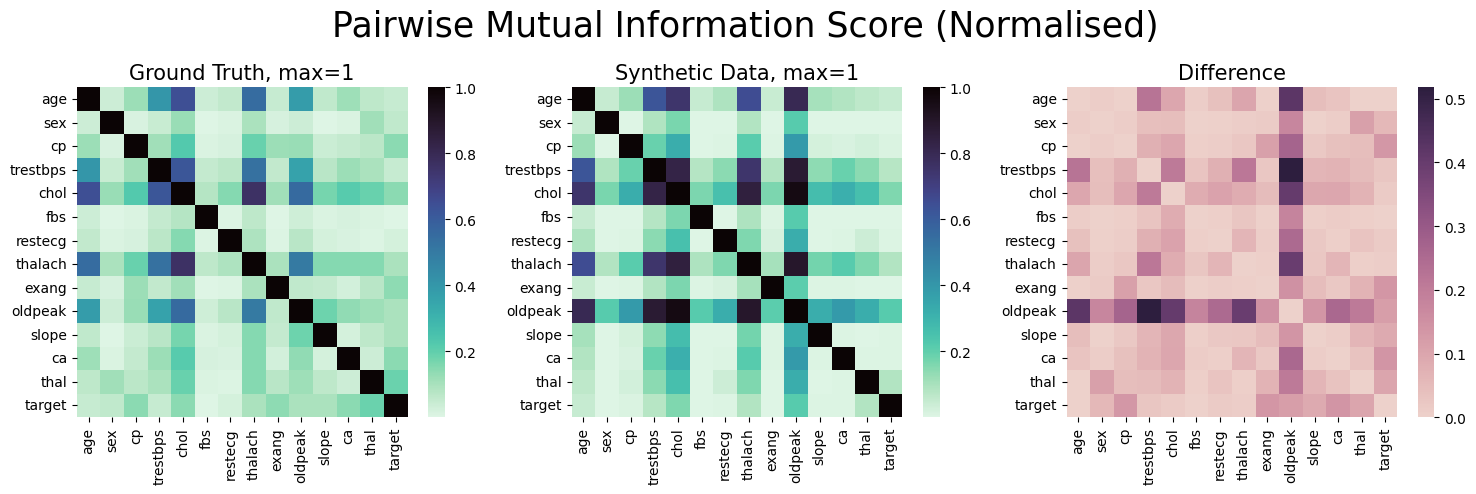

In [34]:
fig, mi_score, pairwise_passed = plot_mi_matrix(df = df, df_syn = df_syn)

In [35]:
print(f"Amount of Mutual Information Retained = {100 * mi_score}%")

Amount of Mutual Information Retained = 91.91%


In [36]:
print(f"Proportion of Pair-wise relationships that retained Mutual Information = {100 * pairwise_passed}%")

Proportion of Pair-wise relationships that retained Mutual Information = 85.71%
